- $\textbf{Author}$: Patrick Mthisi
- $\textbf{Contact details}$: patrickmthisi@hotmail.com

# Dataset and Project Description
## Dataset and problem description
You are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

You must create a model which predicts a probability of each type of toxicity for each comment. The files can be found on:
https://www.kaggle.com/competitions/jigsaw-unintended-bias-in-toxicity-classification/data

File descriptions:
- train.csv - the training set, contains comments with their binary labels
- test.csv - the test set, you must predict the toxicity probabilities for these comments. To deter hand labeling, the test set - contains some comments which are not included in scoring.
- sample_submission.csv - a sample submission file in the correct format
- test_labels.csv - labels for the test data; value of -1 indicates it was not used for scoring; (Note: file added after competition close!)

## Project description
In this project, I built a multi-channel n-gram CNN for multi-label toxicity classification (six labels). The model uses pre-trained GloVe (100d) embeddings to initialize the embedding layer; embeddings are fine-tuned during training. GloVe leverages global co-occurrence statistics while producing embeddings similar in spirit to predictive approaches. Architecturally, the network runs parallel Conv1D branches with kernel sizes 3, 5, and 7 (capturing different n-gram patterns), applies max-pooling and flattening per branch, then concatenates the branch representations and outputs six sigmoid probabilities (one per label).

## Results and conclusion
Using a 5-model ensemble (mean of predicted probabilities), the model achieves strong discrimination across all labels.
Macro ROC AUC ≈ 0.968, with per-label ROC AUCs ranging from 0.957 to 0.984. For imbalanced labels, Precision–Recall is more informative: the ensemble obtains macro Average Precision (mAP) ≈ 0.478, with AP varying substantially by label (e.g., higher for toxic/obscene, lower for rare labels like threat). Overall, the model separates toxic vs non-toxic content well, and PR curves highlight the expected difficulty on rare classes.


In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from matplotlib import pyplot as plt
import seaborn as sns

import re
import string
from pickle import dump, load
import zipfile
import os

from sklearn.metrics import roc_auc_score

from collections import Counter

from nltk.corpus import stopwords
from nltk.probability import FreqDist

from wordcloud import WordCloud

from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPool1D, Bidirectional, LSTM, Flatten, Dense, concatenate
from tensorflow.keras.layers import BatchNormalization, MultiHeadAttention, Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import Sequence, plot_model, model_to_dot
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import load_model

import tensorflow as tf
import datetime
from tqdm import tqdm

from gensim.models import KeyedVectors

print(tf.__version__)


def extract_zip_files(zip_file_path, extract_to_dir):
    # Path to the zip file
    zip_file_path = zip_file_path
    # directory to extract contents
    extract_to_dir = extract_to_dir
    # Extracting the zip file
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            # Extract all contents to the specified directory
            zip_ref.extractall(extract_to_dir)
        print(f"Contents of {zip_file_path} extracted successfully to {extract_to_dir}.")
    except FileNotFoundError:
        print(f"Error: The file {zip_file_path} does not exist.")
    except zipfile.BadZipFile:
        print(f"Error: The file {zip_file_path} is not a valid zip file.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        
# load doc into memory
def load_doc(filename):
    with open(filename, 'r') as file:
        return file.read()
    

def clean_doc(doc):
    tokens = doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', word) for word in tokens]
    tokens = [word for word in tokens if word.isalpha() or word in ['not', 'no']]
    tokens = [word.lower() for word in tokens]
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

# save a dataset to a file
def save_dataset(dataset, filename):
    dump(dataset, open(filename, 'wb'))
    print('Saved: %s' % filename)
    
# load a clean dataset
def load_output(filename):
    return load(open(filename, 'rb'))

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2  # Memory usage in MB

    for col in df.columns:
        col_type = df[col].dtype
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            # Downcast integers
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            # Downcast floats
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        reduction_percent = 100 * (start_mem - end_mem) / start_mem
        print(f"Memory usage decreased to {end_mem:.2f} MB ({reduction_percent:.1f}% reduction)")

    return df

from tensorflow.keras.utils import model_to_dot

def style_keras_dot(dot,
                    default_fill="#E3F2FD",
                    default_border="#1565C0",
                    default_font="#0D47A1"):
    """
    dot: pydot.Dot returned by model_to_dot(model, ...)
    Mutates 'dot' in-place.
    """

    # Set graph-level defaults (may be overridden by per-node attrs)
    dot.set_node_defaults(
        shape="record",
        style="filled",
        fillcolor=default_fill,
        color=default_border,
        fontcolor=default_font
    )

    # Force-override every actual node
    for node in dot.get_nodes():
        name = node.get_name().strip('"')

        # pydot often includes special nodes like 'node', 'graph', 'edge'
        if name in ("node", "graph", "edge"):
            continue

        node.set_shape("record")
        node.set_style("filled")
        node.set_fillcolor(default_fill)
        node.set_color(default_border)
        node.set_fontcolor(default_font)

    return dot


2.19.0


# Load data:

In [3]:
# extract main file
zip_file_path = 'jigsaw-toxic-comment-classification-challenge.zip'
extract_to_dir = './toxic_files'
extract_zip_files(zip_file_path, extract_to_dir)

Contents of jigsaw-toxic-comment-classification-challenge.zip extracted successfully to ./toxic_files.


In [4]:
# extract training zip file:
zip_file_path = './toxic_files/train.csv.zip'
extract_to_dir = './toxic_files/train_file'
extract_zip_files(zip_file_path, extract_to_dir)

# extract test zip file:
zip_file_path = './toxic_files/test.csv.zip'
extract_to_dir = './toxic_files/test_file'
extract_zip_files(zip_file_path, extract_to_dir)

# extract 
zip_file_path = './toxic_files/test_labels.csv.zip'
extract_to_dir = './toxic_files/test_file'
extract_zip_files(zip_file_path, extract_to_dir)

Contents of ./toxic_files/train.csv.zip extracted successfully to ./toxic_files/train_file.
Contents of ./toxic_files/test.csv.zip extracted successfully to ./toxic_files/test_file.
Contents of ./toxic_files/test_labels.csv.zip extracted successfully to ./toxic_files/test_file.


In [5]:
# load datasets
train_df = pd.read_csv('./toxic_files/train_file/train.csv', index_col=0)
test_doc = pd.read_csv('./toxic_files/test_file/test.csv')
ytest = pd.read_csv('./toxic_files/test_file/test_labels.csv')

# reduce memory:
train_df = reduce_mem_usage(train_df)
test_doc = reduce_mem_usage(test_doc)
ytest = reduce_mem_usage(ytest)

# perform data remediation for the test set:
test_df = pd.merge(test_doc, ytest, on='id', how='left')
test_df.set_index('id', inplace=True)

# remove none informative labels
test_df = test_df[~(test_df == -1).any(axis=1)]

# sumarise data sets:
print('\nData summary:')
print(f'Training dataset: {train_df.shape[0]} rows, {train_df.shape[1]} columns')
print(f'Test dataset: {test_df.shape[0]} rows, {test_df.shape[1]} columns')

# split into input and output:
train_docs, ytrain = train_df['comment_text'], train_df.iloc[:, -6:].values.astype(int)
test_docs, ytest = test_df['comment_text'], test_df.iloc[:, -6:].values.astype(int)

# save files:
train_docs = train_docs.to_frame()
test_docs = test_docs.to_frame()
train_docs.to_csv('train_docs.csv'), test_docs.to_csv('test_docs.csv')
save_dataset([ytrain, ytest], 'output.pkl')
save_dataset([train_docs, test_docs], 'input.pkl')

Memory usage decreased to 3.35 MB (65.6% reduction)
Memory usage decreased to 2.34 MB (0.0% reduction)
Memory usage decreased to 2.05 MB (75.0% reduction)

Data summary:
Training dataset: 159571 rows, 7 columns
Test dataset: 63978 rows, 7 columns
Saved: output.pkl
Saved: input.pkl


# Analysing toxicity by type: 
#### NOTE!!!! Cells in this section are not executed due to harmful words which flags this notebook as harmful on Github!!

In [6]:
class toxicity_analyser(object):
    def __init__(self, df, most_common):
        self.df = df
        self.most_common = most_common
        
    def combine_words(self, word_list):
        all_words = []
        for word in word_list:
            all_words += word
        return all_words
        
    def create_word_cloud(self, col_name):
        df = self.df[self.df[col_name] == 1]
        tokens = df['comment_text'].apply(clean_doc)
        reviewed_tokens = self.combine_words(tokens)
        mostcommon = FreqDist(reviewed_tokens).most_common(self.most_common)
        wordcloud = WordCloud(width=1500, height=800, background_color='white').generate(str(mostcommon))
        fig = plt.figure(figsize=(30,10), facecolor='white')
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis('off')
        plt.title(f'Top {self.most_common} Most Common Words', fontsize=25)
        plt.show()

In [7]:
toxicity = toxicity_analyser(train_df, 100)

# Create Vocabulary:

In [14]:
# add doc to vocabulary
def add_doc_to_vocab(filename, vocab):
    doc = load_doc(filename)
    tokens = clean_doc(doc)
    vocab.update(tokens)
    
# save list to file
def save_list(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close

vocab = Counter()
add_doc_to_vocab('train_docs.csv', vocab)
print(len(vocab))
print(vocab.most_common(50))

min_occurance = 2
tokens = [k for k,c in vocab.items() if c >= min_occurance]
print(len(tokens))
# save token to vocavulary
save_list(tokens, 'vocab.text')

212766
[('the', 491916), ('to', 296460), ('of', 223846), ('and', 221212), ('you', 201608), ('is', 175487), ('that', 153679), ('in', 143493), ('it', 128298), ('for', 102129), ('this', 95292), ('not', 92909), ('on', 89218), ('be', 83262), ('as', 76724), ('have', 72026), ('are', 71536), ('your', 62209), ('with', 59396), ('if', 57238), ('article', 55229), ('was', 54418), ('or', 52087), ('but', 50416), ('page', 45521), ('my', 44884), ('an', 44347), ('from', 41275), ('by', 40812), ('do', 39326), ('at', 39244), ('about', 36915), ('me', 36821), ('wikipedia', 35279), ('so', 35247), ('can', 33684), ('what', 32598), ('there', 31207), ('all', 30974), ('talk', 30801), ('has', 30653), ('will', 30327), ('would', 29103), ('its', 28186), ('one', 27880), ('please', 27658), ('like', 27641), ('no', 27355), ('just', 27261), ('they', 27000)]
89418


# Build model: n-gram multihead CNN Model with GloVe Embedding

In [15]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/ 

def load_pkl(filename):
    return load(open(filename, 'rb'))
    
def to_lines(doc, vocab):
    tokens = doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', word) for word in tokens]
    tokens = [word for word in tokens if word.isalpha() or word in ['not', 'no']]
    tokens = [word.lower() for word in tokens]
    tokens = [w for w in tokens if w in vocab]
    tokens = ' '.join(tokens)
    return tokens

def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

def calculate_doc_length(lines):
    return int(round(np.mean([len(s.split()) for s in lines])))


def encode_text(tokenizer, lines, length):
    encoded = tokenizer.texts_to_sequences(lines)
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

from tensorflow.keras.utils import model_to_dot, plot_model

def define_model(vocab_size, length, kernels, weights, embedding_dim=100):
    inputs, combine = [], []
    for kernel in kernels:
        in_layer = Input(shape=(length,))
        embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[weights], trainable=True)(in_layer)
        x = BatchNormalization()(embedding)
        x = Conv1D(filters=32, kernel_size=kernel, activation='relu', kernel_initializer='he_uniform')(x)
        x = Dropout(0.5)(x)
        x = MaxPool1D(pool_size=2)(x)
        x = Flatten()(x)

        inputs.append(in_layer)
        combine.append(x)

    merged = concatenate(combine)
    x = Dense(50, activation='relu', kernel_initializer='he_uniform')(merged)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    outputs = Dense(6, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)

    lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.9)
    optimizer = Adam(learning_rate=lr_schedule)

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['binary_accuracy', AUC(name='roc_auc', multi_label=True, num_labels=6)]
    )
    
    # --- export DOT + PNG (Graphviz via pydot) ---
    dot = model_to_dot(model, show_shapes=True, show_layer_names=True, rankdir="TB")
    dot = style_keras_dot(dot)
    dot.write_png("n_gram_cnn_model_colored.png")
    dot.write("model_colored.dot")


    # default keras plot
    plot_model(model, to_file='n_gram_cnn_model.png', show_shapes=True)

    return model


class DataGenerator(Sequence):
    def __init__(self, texts, labels, tokenizer, max_length, kernels, batch_size=32):
        self.texts = list(texts)
        self.labels = np.asarray(labels, dtype=np.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.kernels = kernels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.texts) / self.batch_size))

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = (idx + 1) * self.batch_size

        batch_texts = self.texts[start:end]
        batch_labels = self.labels[start:end]

        encoded_texts = encode_text(self.tokenizer, batch_texts, self.max_length).astype(np.int32)
        X = tuple([encoded_texts] * len(self.kernels))
        y = np.asarray(batch_labels, dtype=np.float32)

        return X, y

def evaluate_model(make_model_fn, Xtrain, ytrain, Xtest, ytest, kernels, tokenizer, length, n_repeats=5):
    train_generator = DataGenerator(Xtrain, ytrain, tokenizer, length, kernels, batch_size=64)
    test_generator  = DataGenerator(Xtest,  ytest,  tokenizer, length, kernels, batch_size=64)

    acc_scores, auc_scores = [], []
    for i in range(1, n_repeats + 1):
        model = make_model_fn()   # fresh weights each time

        log_dir = f"logs/fit/run_{i}_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tb = tf.keras.callbacks.TensorBoard(
            log_dir=log_dir,
            histogram_freq=0,
            write_graph=True,
            update_freq="epoch",
            profile_batch=0
        )

        es = EarlyStopping(monitor='val_roc_auc', mode='max', patience=3, restore_best_weights=True)
        mc = ModelCheckpoint(f'best_model_iter_{i}.keras', monitor='val_roc_auc', mode='max', verbose=0, save_best_only=True)

        model.fit(train_generator, validation_data=test_generator, epochs=10, verbose=2, callbacks=[tb, es, mc])

        metrics = model.evaluate(test_generator, verbose=0)
        acc, auc = metrics[1], metrics[2]
        print(f'> run={i}: Accuracy={acc * 100:.3f}, ROC AUC={auc * 100:.3f}')
        acc_scores.append(acc)
        auc_scores.append(auc)

    print(f'Mean Accuracy={np.mean(acc_scores) * 100:.3f}, Mean ROC AUC={np.mean(auc_scores) * 100:.3f}')

if __name__ == '__main__':
    # Load vocab
    vocab_filename = 'vocab.text'
    vocab = load_doc(vocab_filename)
    vocab = set(vocab.split())

    # Load datasets
    ytrain, ytest = load_pkl('output.pkl') 
    ytrain = np.asarray(ytrain, dtype=np.float32)
    ytest  = np.asarray(ytest, dtype=np.float32)

    print(ytrain.shape, ytest.shape)  # should be (n_train, 6) and (n_test, 6)

    train_docs, test_docs = load_pkl('input.pkl')

    # Clean training and test docs
    trainLines = train_docs['comment_text'].apply(lambda x: to_lines(x, vocab)).astype(str)
    testLines = test_docs['comment_text'].apply(lambda x: to_lines(x, vocab)).astype(str)

    # Tokenize and encode datasets
    tokenizer = create_tokenizer(trainLines)
    vocab_size = len(tokenizer.word_index) + 1
    length = calculate_doc_length(trainLines)
    print(f'Vocabulary size: {vocab_size}')
    print(f'Average document length: {length}')

    # load the embedding into memory
    embeddings_index = {}
    data_path = '/home/pmthisi/code_env/6_Deep_Learning_for_Natural_Language_Processing/glove_files'
    f = open(f'{data_path}/glove.6B.100d.txt', mode='rt', encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Loaded %s word vector' % len(embeddings_index))

    # create a weight matrix for words in the training docs
    embedding_matrix = np.random.uniform(-0.05, 0.05, size=(vocab_size, 100))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    # Define and evaluate model
    kernels = [3, 5, 7]
    make_model_fn = lambda: define_model(vocab_size, length, kernels, embedding_matrix)
    evaluate_model(make_model_fn, trainLines.tolist(), ytrain, testLines.tolist(), ytest, kernels, tokenizer, length)

(159571, 6) (63978, 6)
Vocabulary size: 89419
Average document length: 62
Loaded 400000 word vector


2026-01-16 09:20:53.528613: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10


/home/pmthisi/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2026-01-16 09:20:57.651126: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


2494/2494 - 469s - 188ms/step - binary_accuracy: 0.9522 - loss: 0.1290 - roc_auc: 0.8507 - val_binary_accuracy: 0.9723 - val_loss: 0.0749 - val_roc_auc: 0.9462
Epoch 2/10
2494/2494 - 461s - 185ms/step - binary_accuracy: 0.9793 - loss: 0.0599 - roc_auc: 0.9358 - val_binary_accuracy: 0.9722 - val_loss: 0.0744 - val_roc_auc: 0.9584
Epoch 3/10
2494/2494 - 490s - 197ms/step - binary_accuracy: 0.9813 - loss: 0.0527 - roc_auc: 0.9515 - val_binary_accuracy: 0.9714 - val_loss: 0.0737 - val_roc_auc: 0.9593
Epoch 4/10
2494/2494 - 463s - 186ms/step - binary_accuracy: 0.9825 - loss: 0.0478 - roc_auc: 0.9620 - val_binary_accuracy: 0.9700 - val_loss: 0.0759 - val_roc_auc: 0.9609
Epoch 5/10
2494/2494 - 453s - 182ms/step - binary_accuracy: 0.9838 - loss: 0.0437 - roc_auc: 0.9686 - val_binary_accuracy: 0.9702 - val_loss: 0.0763 - val_roc_auc: 0.9601
Epoch 6/10
2494/2494 - 481s - 193ms/step - binary_accuracy: 0.9848 - loss: 0.0409 - roc_auc: 0.9725 - val_binary_accuracy: 0.9714 - val_loss: 0.0730 - val_r

> Loaded best_model_iter_1.keras
> Loaded best_model_iter_2.keras
> Loaded best_model_iter_3.keras
> Loaded best_model_iter_4.keras
> Loaded best_model_iter_5.keras


/home/pmthisi/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Macro-average ROC AUC: 0.9677
Macro-average PR AUC: 0.4781


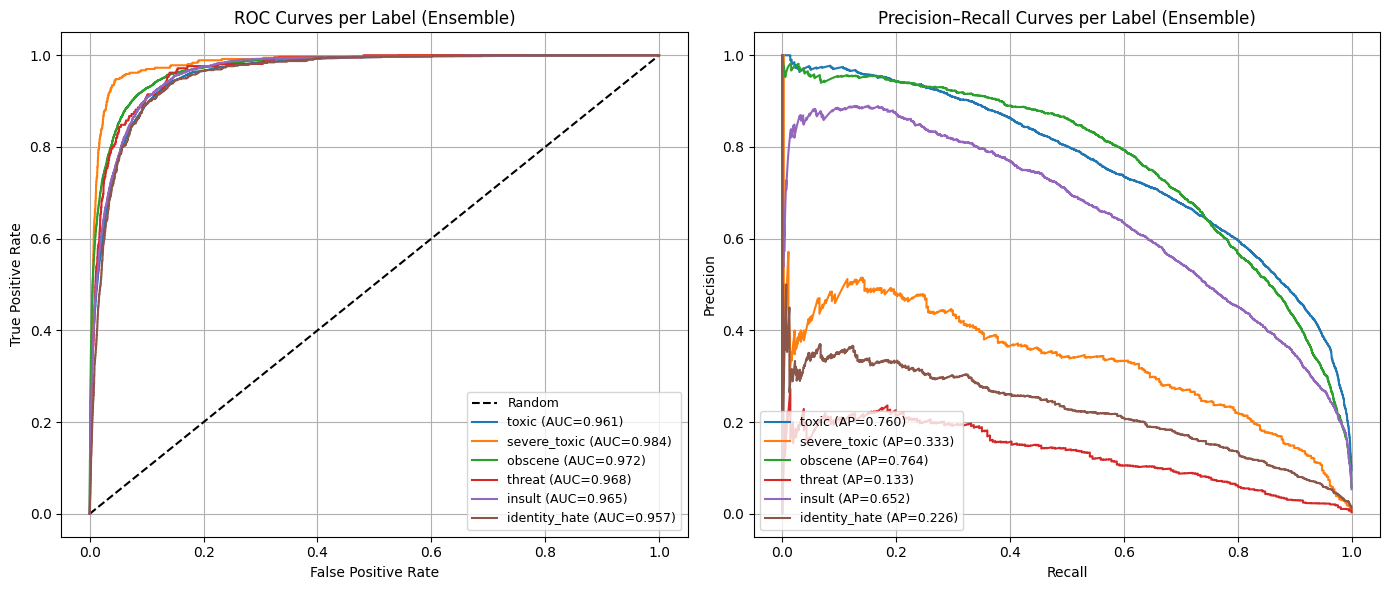

In [17]:
n_members = 5
models = []

test_generator = DataGenerator(testLines.tolist(), ytest, tokenizer, length, kernels, batch_size=64)

# Load models
for j in range(1, n_members + 1):
    filename = f"best_model_iter_{j}.keras"
    m = load_model(filename)
    models.append(m)
    print(f"> Loaded {filename}")

# Predict with each model
preds = [m.predict(test_generator, verbose=0) for m in models]
y_pred_ensemble = np.mean(preds, axis=0)  # (n_samples, 6)

# Macro-average AUC (matches your Keras metric conceptually)
macro_auc = np.mean([
    roc_auc_score(ytest[:, i], y_pred_ensemble[:, i])
    for i in range(6)
])

print(f"Macro-average ROC AUC: {macro_auc:.4f}")

macro_pr_auc = np.mean([
    average_precision_score(ytest[:, i], y_pred_ensemble[:, i])
    for i in range(6)
])
print(f"Macro-average PR AUC: {macro_pr_auc:.4f}")

label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# --- Side-by-side plots ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax_roc, ax_pr = axes

# ROC baseline (random classifier)
ax_roc.plot([0, 1], [0, 1], "k--", label="Random")

for i, label in enumerate(label_names):
    # ROC curve
    fpr, tpr, _ = roc_curve(ytest[:, i], y_pred_ensemble[:, i])
    auc = roc_auc_score(ytest[:, i], y_pred_ensemble[:, i])
    ax_roc.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})")

    # PR curve
    precision, recall, _ = precision_recall_curve(ytest[:, i], y_pred_ensemble[:, i])
    ap = average_precision_score(ytest[:, i], y_pred_ensemble[:, i])
    ax_pr.plot(recall, precision, label=f"{label} (AP={ap:.3f})")

# ROC formatting
ax_roc.set_title("ROC Curves per Label (Ensemble)")
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
ax_roc.grid(True)
ax_roc.legend(loc="lower right", fontsize=9)

# PR formatting
ax_pr.set_title("Precision–Recall Curves per Label (Ensemble)")
ax_pr.set_xlabel("Recall")
ax_pr.set_ylabel("Precision")
ax_pr.grid(True)
ax_pr.legend(loc="lower left", fontsize=9)

plt.tight_layout()
plt.show()
